## Домашняя работа №7.
**Тема: кластеризация, внутренние метрики качества, PCA/t-SNE и "честный" unsupervised-эксперимент на синтетических данных.**

### 0. Импорт необходимых библиотек и вспомогательные функции

#### Необходимые библиотеки и константы

In [82]:
# Для работы с данными
import pandas as pd
import numpy as np
import json
import datetime

# Для графиков
import matplotlib.pyplot as plt

# Масштабирование
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
# Пайплайн
from sklearn.pipeline import Pipeline
# Модели
from sklearn.cluster import KMeans, DBSCAN
# Метрики
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score

from sklearn.decomposition import PCA

CSV_PATH = "./data/"  # путь к csv
FIG_PATH = "./data/artifacts/figures/"  # путь для сохранения графиков
S_CSV_PATH = "./data/artifacts/labels/"  # путь для сохранения id-label
ID_COLUMN_NAME = "sample_id"  # столбец с id
RANDOM_STATE = 39  # для воспроизводимости результата

# Для KMEANS
K_ARR = list(range(2, 21))  # размах K для перебора (модель KMeans)
N_INIT = 10  # число запусков с разными центроидами для KMeans

# Для DBSCAN
EPS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]  # Радиус окрестности
MIN_SAMPLES = [3, 5, 7, 10]  # Минимальное число узлов для центра кластера


FIGSIZE = (12, 6)  # для графиков
# Для metrics_summary.json
METRICS_SUMMARY = {
    "datasets": [],
    "last_updated": None,
    "total_records": 0
}

FINAL_CHOICES = []  # для сохранения конфигураций


#### Вспомогательные функции

Функция для оценки моделей `KMeans`

In [83]:
def rate_kmeans(X, n_clusters=2, n_init=1, dataset_name="", 
                   plot_show=False, random_state=RANDOM_STATE, figsize=FIGSIZE):
    """
    Оценивает KMeans кластеризацию.
    
    Parameters:
    -----------
    X : array, данные (уже масштабированные)
    n_clusters : int, количество кластеров
    n_init : int, количество инициализаций
    dataset_name : str, название датасета для заголовков
    plot_show : bool, показывать ли график сразу
    random_state : int, для воспроизводимости
    figsize : tuple, размер фигуры (ширина, высота)
    
    Returns:
    --------
    dict : результаты кластеризации, метрики и figure
    """
    
    # 1. Создаём и обучаем модель
    kmeans = KMeans(
        n_clusters=n_clusters,
        n_init=n_init,
        random_state=random_state
    )
    
    labels = kmeans.fit_predict(X)
    
    # 2. Вычисляем метрики
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    
    # 3. Создаём фигуру с двумя графиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # 3.1 PCA scatter plot (левый график)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    explained_var = pca.explained_variance_ratio_.sum()
    
    scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=labels, cmap='viridis', alpha=0.7, s=30)
    ax1.set_xlabel("PCA Component 1")
    ax1.set_ylabel("PCA Component 2")
    ax1.set_title(f"KMeans (k={n_clusters})\nPCA ({explained_var:.1%} дисперсии)")
    plt.colorbar(scatter, ax=ax1, label='Cluster')
    ax1.grid(alpha=0.3)
    
    # 3.2 Распределение по кластерам (правый график)
    cluster_counts = np.bincount(labels)
    clusters = np.arange(n_clusters)
    
    bars = ax2.bar(clusters, cluster_counts, color='steelblue', alpha=0.8)
    ax2.set_xlabel('Номер кластера')
    ax2.set_ylabel('Количество точек')
    ax2.set_title(f'Распределение по кластерам (k={n_clusters})')
    ax2.set_xticks(clusters)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, count in zip(bars, cluster_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(cluster_counts)*0.01,
                f'{count}', ha='center', va='bottom', fontsize=10)
    
    # Общий заголовок для всей фигуры
    fig.suptitle(f'Датасет: {dataset_name} | KMeans (k={n_clusters})', 
                fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # 4. Создаем словарь результатов
    results = {
        'model': kmeans,
        'labels': labels,
        'n_clusters': n_clusters,
        'cluster_sizes': cluster_counts,
        'inertia': kmeans.inertia_,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz,
        'figure': fig,
        'pca_data': {
            'X_pca': X_pca,
            'explained_variance': explained_var,
            'pca_model': pca
        }
    }
    
    
    if plot_show:
        plt.show()
    else:
        plt.close(fig)
    
    return results

Функция для оценки моделей `DBSCAN`

In [84]:
def rate_dbscan(X, eps=0.1, min_samples=2, dataset_name="", 
                plot_show=False, figsize=FIGSIZE):
    """
    Оценивает DBSCAN кластеризацию.
    
    Parameters:
    -----------
    X : array, данные (уже масштабированные)
    eps : float, радиус окрестности
    min_samples : int, минимальное количество точек
    dataset_name : str, название датасета для заголовков
    plot_show : bool, показывать ли график сразу
    figsize : tuple, размер фигуры
    
    Returns:
    --------
    dict : результаты кластеризации, метрики и figure
    """
    
    # 1. Создаём и обучаем модель
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    
    # 2. Анализируем результаты DBSCAN
    labels_array = np.asarray(labels)
    unique_labels = sorted(set(labels_array))
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    noise_mask = labels_array == -1
    n_noise = np.sum(noise_mask)
    noise_ratio = n_noise / len(labels_array)
    
    # 3. Вычисляем метрики только на non-noise точках
    if n_clusters >= 2 and np.sum(~noise_mask) > 0:
        X_no_noise = X[~noise_mask]
        labels_no_noise = labels_array[~noise_mask]
        
        # Дополнительная проверка: сколько уникальных меток осталось
        unique_no_noise = set(labels_no_noise)
        if len(unique_no_noise) >= 2:
            silhouette = silhouette_score(X_no_noise, labels_no_noise)
            davies_bouldin = davies_bouldin_score(X_no_noise, labels_no_noise)
            calinski_harabasz = calinski_harabasz_score(X_no_noise, labels_no_noise)
        else:
            silhouette = np.nan
            davies_bouldin = np.nan
            calinski_harabasz = np.nan
    else:
        silhouette = np.nan
        davies_bouldin = np.nan
        calinski_harabasz = np.nan
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    ax1 = plt.subplot(121)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    explained_var = pca.explained_variance_ratio_.sum()
    
    for lab in unique_labels:
        mask = labels_array == lab
        if lab == -1:  # шум
            ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                       s=20, marker="x", color='gray', alpha=0.5, label="шум (-1)")
        else:
            ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                       s=30, label=f"кластер {lab}")
    
    ax1.set_xlabel("PCA Component 1")
    ax1.set_ylabel("PCA Component 2")
    ax1.set_title(f"DBSCAN (eps={eps}, min={min_samples})\n")
    ax1.legend(loc='best', fontsize='small')
    ax1.grid(True, alpha=0.25)
    
    ax2 = plt.subplot(122)
    
    cluster_sizes = []
    cluster_labels = []
    for lab in unique_labels:
        if lab != -1:
            cluster_sizes.append(np.sum(labels_array == lab))
            cluster_labels.append(f'C{lab}')
    
    if n_noise > 0:
        cluster_sizes.append(n_noise)
        cluster_labels.append('шум')
    
    colors = ['steelblue'] * len([lab for lab in unique_labels if lab != -1])
    if n_noise > 0:
        colors.append('lightgray')
    
    bars = ax2.bar(cluster_labels, cluster_sizes, color=colors, alpha=0.8)
    
    for bar, count in zip(bars, cluster_sizes):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + max(cluster_sizes)*0.01,
                f'{count}', ha='center', va='bottom', fontsize=10)
    
    ax2.set_xlabel('Кластеры')
    ax2.set_ylabel('Количество точек')
    ax2.set_title(f'Распределение по кластерам\nВсего точек: {len(X)}')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    fig.suptitle(f'Датасет: {dataset_name} | DBSCAN', 
                fontsize=10, fontweight='bold', y=1.02)
    
    
    results = {
        'model': dbscan,
        'labels': labels_array,
        'eps': eps,
        'min_samples': min_samples,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': noise_ratio,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin,
        'calinski_harabasz': calinski_harabasz,
        'figure': fig,
        'pca_data': {
            'X_pca': X_pca,
            'explained_variance': explained_var,
            'pca_model': pca
        }
    }
    
    if plot_show:
        plt.show()
    else:
        plt.close(fig)
    
    return results

Функция для заполнения метрик модели типа `KMeans` в `METRICS_SUMMARY`

In [85]:
def add_kmeans_metrics(best_result, dataset_name, n_init=N_INIT, random_state=RANDOM_STATE):
    """
    Добавляет метрики KMeans модели в глобальный словарь METRICS_SUMMARY.
    
    Parameters:
    -----------
    best_result : dict
        Результат работы rate_kmeans() для лучшей модели
    dataset_name : str
        Название датасета
    n_init : int
        Значение n_init параметра
    random_state : int
        Значение random_state параметра
    """
    
    dataset_metrics = {
        "dataset_name": dataset_name,
        "added_timestamp": datetime.datetime.now().isoformat(),
        "best_K_model": {
            "algorithm": "KMeans",
            "parameters": {
                "n_clusters": int(best_result['n_clusters']),
                "n_init": int(n_init),
                "random_state": int(random_state)
            },
            "metrics": {
                "silhouette_score": float(best_result['silhouette']),
                "davies_bouldin_score": float(best_result['davies_bouldin']),
                "calinski_harabasz_score": float(best_result['calinski_harabasz']),
                "inertia": float(best_result['inertia'])
            },
            "clusters": {
                "count": int(best_result['n_clusters']),
                "sizes": [int(size) for size in best_result['cluster_sizes']],
            },
            "pca_info": {
                "explained_variance": float(best_result['pca_data']['explained_variance']),
                "n_components": 2
            }
        }
    }
    
    # Добавляем в глобальный словарь
    METRICS_SUMMARY["datasets"].append(dataset_metrics)
    METRICS_SUMMARY["last_updated"] = datetime.datetime.now().isoformat()
    METRICS_SUMMARY["total_records"] = len(METRICS_SUMMARY["datasets"])
    
    return dataset_metrics

Функция для заполнения метрик модели типа `DBSCAN` в `METRICS_SUMMARY`

In [86]:
def add_dbscan_metrics(best_result, dataset_name):
    """
    Добавляет метрики DBSCAN модели в глобальный словарь METRICS_SUMMARY.
    
    Parameters:
    -----------
    best_result : dict
        Результат работы rate_dbscan() для лучшей модели
    dataset_name : str
        Название датасета
    """
    
    cluster_sizes = []
    labels_array = np.asarray(best_result['labels'])
    unique_labels = sorted(set(labels_array))
    
    for label in unique_labels:
        if label != -1:
            size = int(np.sum(labels_array == label))
            cluster_sizes.append(size)
    
    dataset_metrics = {
        "dataset_name": dataset_name,
        "added_timestamp": datetime.datetime.now().isoformat(),
        "best_DB_model": {
            "algorithm": "DBSCAN",
            "parameters": {
                "eps": float(best_result['eps']),
                "min_samples": int(best_result['min_samples'])
            },
            "metrics": {
                "silhouette_score": float(best_result['silhouette']) if not np.isnan(best_result['silhouette']) else None,
                "davies_bouldin_score": float(best_result['davies_bouldin']) if not np.isnan(best_result['davies_bouldin']) else None,
                "calinski_harabasz_score": float(best_result['calinski_harabasz']) if not np.isnan(best_result['calinski_harabasz']) else None
            },
            "clusters": {
                "count": int(best_result['n_clusters']),
                "sizes": cluster_sizes,
                "noise_points": int(best_result['n_noise']),
                "noise_ratio": float(best_result['noise_ratio'])
            },
            "pca_info": {
                "explained_variance": float(best_result['pca_data']['explained_variance']),
                "n_components": 2
            }
        }
    }
    
    METRICS_SUMMARY["datasets"].append(dataset_metrics)
    METRICS_SUMMARY["last_updated"] = datetime.datetime.now().isoformat()
    METRICS_SUMMARY["total_records"] = len(METRICS_SUMMARY["datasets"])
    
    return dataset_metrics

Функция для сохранения всех данных из `METRICS_SUMMARY` в `metrics_summary.json`

In [87]:
def save_metrics_to_json(filename="./data/artifacts/metrics_summary.json"):
    """
    Сохраняет все собранные метрики из METRICS_SUMMARY в JSON файл.
    
    Parameters:
    -----------
    filename : str
        Имя файла для сохранения
    """
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(METRICS_SUMMARY, f, indent=2, ensure_ascii=False, 
                  default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else str(x))
    
    return True

Функция сохранения меток кластеризациив CSV файл

In [88]:
def save_cluster_labels(filepath, best_result, dataset_with_ids):
    """
    Сохраняет метки кластеров в CSV файл
    
    Parameters:
    -----------
    filepath : str
        Путь файла .csv для сохранения
    best_result : dict
        Результат работы rate_kmeans() или rate_dbscan() для лучшей модели
    dataset_with_ids : pd.DataFrame
        Исходный датасет с колонкой sample_id
    """
    
    # Создаём DataFrame с метками
    labels_df = pd.DataFrame({
        'sample_id': dataset_with_ids['sample_id'],
        'cluster_label': best_result['labels']
    })
    
    # Сохраняем
    labels_df.to_csv(filepath, index=False)
    print(f"Метки сохранены в {filepath}")
    print("Информация об итоговом датасете")
    display(labels_df.info())
    
    return labels_df

Функция для сохранения лучших конфигураций для каждого датасета

In [89]:
def save_final_choices_to_json(filename="./data/artifacts/best_configs.json"):
    """
    Сохраняет финальные выборы моделей в JSON файл
    """
    
    configs_to_save = {
        "last_updated": datetime.datetime.now().isoformat(),
        "datasets": []
    }
    
    for choice in FINAL_CHOICES:
        model = choice["model"]
        
        if 'n_clusters' in model:  # KMeans
            parameters = {
                "n_clusters": int(model['n_clusters']),
                "n_init": N_INIT if 'n_init' in choice.get('model', {}) else N_INIT,
                "random_state": RANDOM_STATE
            }
            algorithm = "KMeans"
            metrics = {
                "silhouette_score": float(model['silhouette']),
                "davies_bouldin_score": float(model['davies_bouldin']),
                "calinski_harabasz_score": float(model['calinski_harabasz'])
            }
            if 'inertia' in model:
                metrics["inertia"] = float(model['inertia'])
                
        elif 'eps' in model:
            parameters = {
                "eps": float(model['eps']),
                "min_samples": int(model['min_samples'])
            }
            algorithm = "DBSCAN"
            metrics = {
                "silhouette_score": float(model['silhouette']) if not np.isnan(model['silhouette']) else None,
                "davies_bouldin_score": float(model['davies_bouldin']) if not np.isnan(model['davies_bouldin']) else None,
                "calinski_harabasz_score": float(model['calinski_harabasz']) if not np.isnan(model['calinski_harabasz']) else None,
                "noise_ratio": float(model['noise_ratio']),
                "n_clusters": int(model['n_clusters']),
                "n_noise": int(model['n_noise'])
            }
        
        dataset_config = {
            "dataset_name": choice["dataset_name"],
            "final_choice": {
                "algorithm": algorithm,
                "parameters": parameters,
                "metrics": metrics,
                "reasoning": choice["reason"]
            }
        }
        
        configs_to_save["datasets"].append(dataset_config)
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(configs_to_save, f, indent=2, ensure_ascii=False,
                  default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else str(x))
    
    return configs_to_save

### 1. Загрузка данных и первичный анализ

#### 1.1. Датасет `S07-hw-dataset-01.csv`

Загрузим данные из датасета `S07-hw-dataset-01.csv`, создадим таблицу признаков и выведем первые пять срок

In [90]:
first_dataset = pd.read_csv(filepath_or_buffer=f"{CSV_PATH}S07-hw-dataset-01.csv", sep=",")
display(first_dataset.head())

first_X = first_dataset.drop(columns=['sample_id']).copy()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


Получим информацию о столбцах датасета

In [91]:
display(first_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


None

Получим базовую описательную статистику столбцов датасета

In [92]:
display(first_dataset.describe())

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


Проверим пропуски в столбцах датасета и типы данных признаков

In [93]:
if first_dataset.isnull().any().any():
    print("Пропуски найдены в следующих столбцах:")
    print(first_dataset.isnull().sum()[first_dataset.isnull().sum() > 0])
else:
    print("Пропусков нет")

print("\nТипы данных столбцов")
print(first_dataset.dtypes)

Пропусков нет

Типы данных столбцов
sample_id      int64
f01          float64
f02          float64
f03          float64
f04          float64
f05          float64
f06          float64
f07          float64
f08          float64
dtype: object


**Выводы**

Первый датасет содержит 12000 строк и 9 столбцов, из которых `sample_id` не является признаком -> признаков 8. В данных нет пропусков, все признаки типа `float64`. Признаки в разных масштабах (приблизительно: [-20, 24], [-134, 75] и так далее). Данные могут содержать шумы из-за больших разбросов у некоторых признаков. Потребуется масштабирование.

#### 1.2. Датасет `S07-hw-dataset-02.csv`

Загрузим данные из датасета `S07-hw-dataset-02.csv`, создадим таблицу признаков и выведем первые пять срок

In [94]:
second_dataset = pd.read_csv(filepath_or_buffer=f"{CSV_PATH}S07-hw-dataset-02.csv", sep=",")
display(second_dataset.head())

second_X = second_dataset.drop(columns=['sample_id']).copy()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


Получим информацию о столбцах датасета

In [95]:
display(second_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


None

Получим базовую описательную статистику столбцов датасета

In [96]:
display(second_dataset.describe())

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


Проверим пропуски в столбцах датасета и типы данных признаков

In [97]:
if second_dataset.isnull().any().any():
    print("Пропуски найдены в следующих столбцах:")
    print(second_dataset.isnull().sum()[second_dataset.isnull().sum() > 0])
else:
    print("Пропусков нет")

print("\nТипы данных столбцов")
print(second_dataset.dtypes)

Пропусков нет

Типы данных столбцов
sample_id      int64
x1           float64
x2           float64
z_noise      float64
dtype: object


**Выводы**

Второй датасет содержит 8000 строк и 4 столбца, из которых `sample_id` не является признаком -> признаков 3. В данных нет пропусков, все признаки типа `float64`.

Признаки x1 и x2 имеют схожий масштаб (приблизительно от -2.5 до 3.0) и симметричное распределение. Признак z_noise существенно отличается по масштабу и имеет значительно больший разброс, что может указывать на наличие шумов или выбросов. Перед использованием в моделях потребуется масштабирование.

#### 1.3. Датасет `S07-hw-dataset-03.csv`

Загрузим данные из датасета `S07-hw-dataset-03.csv`, создадим таблицу признаков и выведем первые пять срок

In [98]:
third_dataset = pd.read_csv(filepath_or_buffer=f"{CSV_PATH}S07-hw-dataset-03.csv", sep=",")
display(third_dataset.head())

third_X = third_dataset.drop(columns=['sample_id']).copy()

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


Получим информацию о столбцах датасета

In [99]:
display(third_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


None

Получим базовую описательную статистику столбцов датасета

In [100]:
display(third_dataset.describe())

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


Проверим пропуски в столбцах датасета и типы данных признаков

In [101]:
if second_dataset.isnull().any().any():
    print("Пропуски найдены в следующих столбцах:")
    print(second_dataset.isnull().sum()[second_dataset.isnull().sum() > 0])
else:
    print("Пропусков нет")

print("\nТипы данных столбцов")
print(second_dataset.dtypes)

Пропусков нет

Типы данных столбцов
sample_id      int64
x1           float64
x2           float64
z_noise      float64
dtype: object


**Выводы**

Третий датасет содержит 15000 строк и 5 столбцов, из которых `sample_id` не является признаком → признаков 4. В данных нет пропусков, все признаки типа `float64`.

Признаки x1 и x2 имеют схожий масштаб (диапазон приблизительно от -10 до 16). Признак f_corr также имеет умеренный разброс в диапазоне от -5.2 до 5.8. Признак f_noise отличается меньшим разбросом (от -8.8 до 11.3), но показывает заметную дисперсию.

Все признаки находятся в разных масштабах относительно друг друга. Распределения признаков не демонстрируют явных признаков сильных выбросов. Перед использованием потребуется масштабирование. 

### 2. Препроцессинг

Так как в данных присутствуют только числовые признаки без пропусков, будем использовать только масштабирование (из-за разных диапазонов значений признаков) для числовых признаков `StandardScaler`.

In [102]:
pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# Масштабирование признаков для каждого датасета
first_X_scaled = pipeline.fit_transform(first_X)
second_X_scaled = pipeline.fit_transform(second_X)
third_X_scaled = pipeline.fit_transform(third_X)

### 3. Модели недели 7

В качестве основной метрики для оценки качества кластеризации выбран **`Silhouette-score`** (метрика даёт числовую оценку от -1 до 1), потому что он одновременно оценивает насколько точки близки к своему центру кластера (компактность) и насколько далеки от соседних кластеров (разделённость). Это позволяет избежать ситуаций, когда кластеры либо слишком размазаны, либо неестественно дробятся. 

Индекс Дэвиса-Болдина (**`Davies-Bouldin Index`**) служит дополнительной метрикой, фокусирующейся на соотношении внутрикластерной компактности и межкластерной удалённости. Индекс вычисляется как среднее значение для всех кластеров максимального отношения суммы их внутренних разбросов (средних расстояний объектов до центроидов) к расстоянию между центрами этих кластеров. Чем меньше значение индекса Дэвиса-Болдина, тем лучше качество кластеризации,

Индекс Калински-Харабаса (**`Calinski-Harabasz Index`**), также известный как критерий дисперсионного отношения, оценивает качество кластеризации через соотношение межкластерной дисперсии к внутрикластерной дисперсии, нормированное на количество кластеров и объектов. Высокие значения этого индекса указывают на хорошее разделение данных.

#### 3.1. Датасет `S07-hw-dataset-01.csv`

Рассмотрим модели `KMeans` и `DBSCAN` для первого датасета. Для `DBSCAN` оценка проводится только на точках, отнесённых к кластерам, исключая шумовые объекты.

##### 3.1.1. `KMeans` - К-средних

Переберем значения для K в диапазоне `K_ARR` и выберем лучшую модель по метрике `Silhouette Score`.

In [103]:
all_results_first = []
silhouette_scores = []

for k in K_ARR:
    result = rate_kmeans(
        X=first_X_scaled, 
        n_clusters=k, 
        n_init=N_INIT, 
        dataset_name="S07-hw-dataset-01",
        plot_show=False,
        random_state=RANDOM_STATE
    )
    
    all_results_first.append(result)
    silhouette_scores.append(result['silhouette'])

best_k_silhouette = K_ARR[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)
print(f"Лучшее число кластеров: {best_k_silhouette}")
print(f"Лучшее значение silhouette-score: {best_k_silhouette}")

best_result_idx = np.argmax(silhouette_scores)
best_kmeans_result_first = all_results_first[best_result_idx]

Лучшее число кластеров: 2
Лучшее значение silhouette-score: 2


Получим информацию о метриках лучшей модели

In [104]:
print(f"МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: KMeans с k = {best_k_silhouette}")
print("="*50)

print(f"Основные метрики:")
print(f"  - Silhouette Score:       {best_silhouette:.4f}")
print(f"  - Davies-Bouldin Score:   {best_kmeans_result_first['davies_bouldin']:.4f}")
print(f"  - Calinski-Harabasz Score: {best_kmeans_result_first['calinski_harabasz']:.1f}")
print(f"  - Inertia:                {best_kmeans_result_first['inertia']:.2f}")

print(f"\nХарактеристики кластеров:")
print(f"  - Количество кластеров:   {best_k_silhouette}")
print(f"  - Размеры кластеров:      {best_kmeans_result_first['cluster_sizes']}")

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: KMeans с k = 2
Основные метрики:
  - Silhouette Score:       0.5216
  - Davies-Bouldin Score:   0.6853
  - Calinski-Harabasz Score: 11787.0
  - Inertia:                48425.91

Характеристики кластеров:
  - Количество кластеров:   2
  - Размеры кластеров:      [9600 2400]


Выведем информацию о лучшей модели

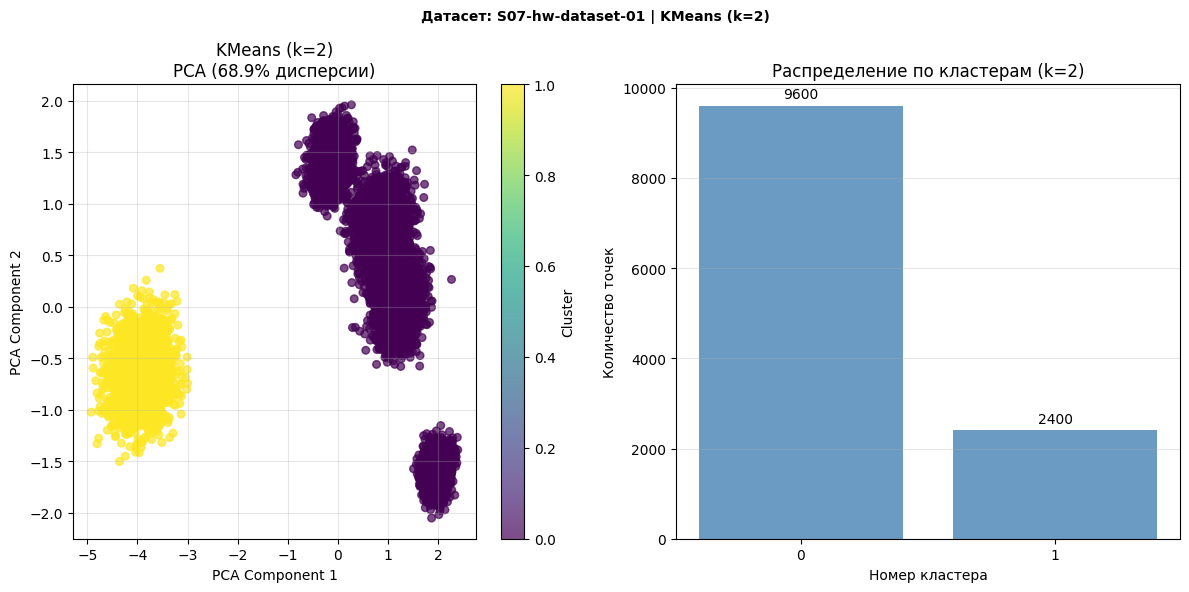

In [105]:
display(best_kmeans_result_first["figure"])
best_kmeans_result_first["figure"].savefig(f"{FIG_PATH}best_kmeans_first_dataset.png")

Изобразим зависимость `Silhouette-score` от `K`

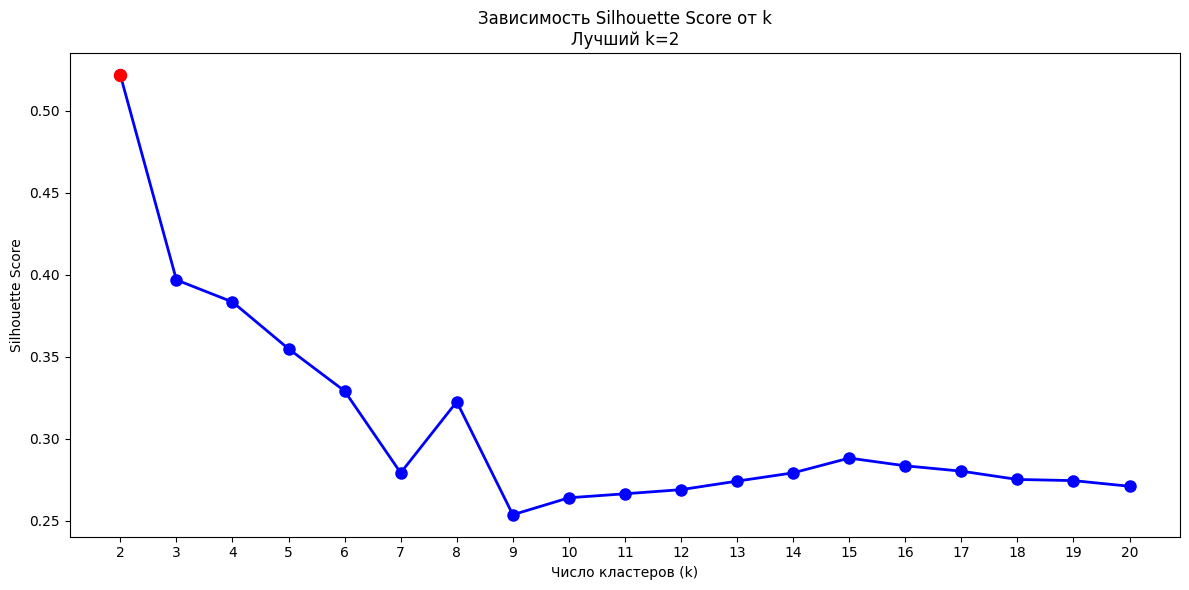

In [106]:
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.plot(K_ARR, silhouette_scores, 'bo-', linewidth=2, markersize=8)

ax.scatter(best_k_silhouette, best_silhouette, color='red', s=75, zorder=2)

ax.set_xlabel('Число кластеров (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title(f'Зависимость Silhouette Score от k\nЛучший k={best_k_silhouette}')

ax.set_xticks(K_ARR)
fig.savefig(f"{FIG_PATH}k_vs_s_sc_first_dataset.png")
plt.tight_layout()
plt.show()

Сохраним лучшую модель типа `KMeans`

In [107]:
add_kmeans_metrics(best_result=best_kmeans_result_first, dataset_name="S07-hw-dataset-01")
pass

##### 3.1.2. `DBSCAN`

Выполним перебор параметров для моделей `DBSCAN`

In [108]:
all_dbscan_results = []
valid_models = []

for eps in EPS:
    for min_samples in MIN_SAMPLES:
        result = rate_dbscan(
            X=first_X_scaled,
            eps=eps,
            min_samples=min_samples,
            dataset_name="S07-hw-dataset-01",
            plot_show=False
        )
        
        all_dbscan_results.append(result)
        
        # Добавляем в валидные только если ≥2 кластеров и метрика не NaN
        if result['n_clusters'] >= 2 and not np.isnan(result['silhouette']):
            valid_models.append(result)


best_dbscan_result_first = max(valid_models, 
                              key=lambda x: x['silhouette'])

print(f"\nЛучшие параметры DBSCAN: eps={best_dbscan_result_first['eps']}, min_samples={best_dbscan_result_first['min_samples']}")
print(f"Лучшее значение silhouette-score: {best_dbscan_result_first['silhouette']:.4f}")
print(f"Количество кластеров: {best_dbscan_result_first['n_clusters']}")
print(f"Доля шума: {best_dbscan_result_first['noise_ratio']:.1%}")



Лучшие параметры DBSCAN: eps=0.6, min_samples=10
Лучшее значение silhouette-score: 0.3845
Количество кластеров: 5
Доля шума: 1.9%


Получим информацию о метриках лучшей модели

In [109]:
print(f"МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: DBSCAN")
print("="*50)

print(f"Параметры модели:")
print(f"  - eps:                    {best_dbscan_result_first['eps']}")
print(f"  - min_samples:            {best_dbscan_result_first['min_samples']}")

print(f"\nОсновные метрики (без учёта шума):")
print(f"  - Silhouette Score:       {best_dbscan_result_first['silhouette']:.4f}")
print(f"  - Davies-Bouldin Score:   {best_dbscan_result_first['davies_bouldin']:.4f}")
print(f"  - Calinski-Harabasz Score: {best_dbscan_result_first['calinski_harabasz']:.1f}")

print(f"\nХарактеристики кластеризации:")
print(f"  - Количество кластеров:   {best_dbscan_result_first['n_clusters']}")
print(f"  - Доля шума:              {best_dbscan_result_first['noise_ratio']:.1%}")
print(f"  - Количество шумовых точек: {best_dbscan_result_first['n_noise']}")
print(f"  - Общее количество точек: {len(best_dbscan_result_first['labels'])}")

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: DBSCAN
Параметры модели:
  - eps:                    0.6
  - min_samples:            10

Основные метрики (без учёта шума):
  - Silhouette Score:       0.3845
  - Davies-Bouldin Score:   1.2397
  - Calinski-Harabasz Score: 8561.5

Характеристики кластеризации:
  - Количество кластеров:   5
  - Доля шума:              1.9%
  - Количество шумовых точек: 230
  - Общее количество точек: 12000


Выведем информацию о лучшей модели

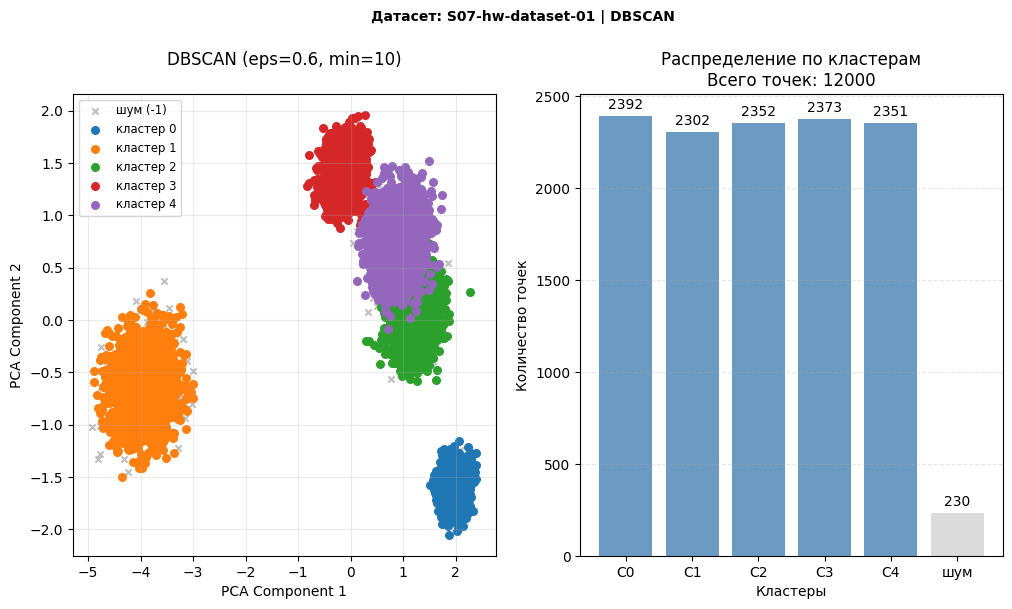

In [110]:
display(best_dbscan_result_first["figure"])
best_dbscan_result_first["figure"].savefig(f"{FIG_PATH}best_dbscan_first_dataset.png")

Сохраним лучшую модель типа `DBSCAN`

In [111]:
add_dbscan_metrics(best_result=best_dbscan_result_first, dataset_name="S07-hw-dataset-01")
pass

##### 3.1.3. Выводы по датасету `S07-hw-dataset-01.csv`

Проведем сравнительный анализ метрик лучших моделей `KMeans` и `DBSCAN` на данном датасете 

In [112]:
print("\n=== СРАВНИТЕЛЬНЫЙ АНАЛИЗ ===")
print(f"KMeans: silhouette={best_kmeans_result_first['silhouette']:.3f}, "
      f"Davies-Bouldin={best_kmeans_result_first['davies_bouldin']:.3f}, "
      f"Calinski-Harabasz={best_kmeans_result_first['calinski_harabasz']:.3f}, "
      f"кластеры={best_kmeans_result_first['n_clusters']}")
print(f"DBSCAN: silhouette={best_dbscan_result_first['silhouette']:.3f}, "
      f"Davies-Bouldin={best_dbscan_result_first['davies_bouldin']:.3f}, "
      f"Calvinski=Harabasz={best_dbscan_result_first['calinski_harabasz']:.3f}, "
      f"кластеры={best_dbscan_result_first['n_clusters']}, "
      f"шум={best_dbscan_result_first['noise_ratio']:.1%}")


=== СРАВНИТЕЛЬНЫЙ АНАЛИЗ ===
KMeans: silhouette=0.522, Davies-Bouldin=0.685, Calinski-Harabasz=11786.955, кластеры=2
DBSCAN: silhouette=0.385, Davies-Bouldin=1.240, Calvinski=Harabasz=8561.539, кластеры=5, шум=1.9%


Лучшая модель

In [113]:
best_model_result_first = best_kmeans_result_first
FINAL_CHOICES.append({
    "dataset_name": "S07-hw-dataset-01",
    "model": best_kmeans_result_first,
    "reason": "KMeans показал превосходство по всем метрикам: silhouette=0.522 vs 0.385, "
             "Davies-Bouldin=0.685 vs 1.240, Calinski-Harabasz=11787 vs 8562. "
             "Визуализация PCA подтверждает естественное разделение на две сферические группы."
})

Сохраним результаты кластеризации в `labels_hw07_ds1.csv`

In [114]:
save_cluster_labels(f"{S_CSV_PATH}labels_hw07_ds1.csv", best_result=best_model_result_first, dataset_with_ids=first_dataset)
pass

Метки сохранены в ./data/artifacts/labels/labels_hw07_ds1.csv
Информация об итоговом датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   sample_id      12000 non-null  int64
 1   cluster_label  12000 non-null  int32
dtypes: int32(1), int64(1)
memory usage: 140.8 KB


None

**Итоги по датасету**

Данные содержали признаки в разных масштабах, что потребовало предварительного масштабирования. Выбросы практически отсутствовали.

`KMeans` продемонстрировал явное преимущество по всем метрикам качества: силуэт-коэффициент (0.522 против 0.385 у `DBSCAN`), индекс Дэвиса-Болдина (0.685 против 1.240) и индекс Калински-Харабаса (11787 против 8561). Это указывает на более чёткое и стабильное разделение данных. 

`DBSCAN` с различными параметрами выделял чрезмерное число кластеров, что снижало интерпретируемость, и проигрывал по основным метрикам. В случае с *eps=0.5, min_samples=3* (наилучшие гиперпараметры среди перебираемых) `DBSCAN` выделил 5 кластеров, но проиграл `KMeans` по метрикам, так как получил 4 (из 5) довольно близких кластера.

#### 3.2. Датасет `S07-hw-dataset-02.csv`

Рассмотрим модели `KMeans` и `DBSCAN` для первого датасета. Для `DBSCAN` оценка проводится только на точках, отнесённых к кластерам, исключая шумовые объекты.

##### 3.2.1. `KMeans` - К-средних

Переберем значения для K в диапазоне `K_ARR` и выберем лучшую модель по метрике `Silhouette Score`.

In [115]:
all_results_second = []
silhouette_scores = []

for k in K_ARR:
    result = rate_kmeans(
        X=second_X_scaled, 
        n_clusters=k, 
        n_init=N_INIT, 
        dataset_name="S07-hw-dataset-02",
        plot_show=False,
        random_state=RANDOM_STATE
    )
    
    all_results_second.append(result)
    silhouette_scores.append(result['silhouette'])

best_k_silhouette = K_ARR[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)
print(f"Лучшее число кластеров: {best_k_silhouette}")
print(f"Лучшее значение silhouette-score: {best_k_silhouette}")

best_result_idx = np.argmax(silhouette_scores)
best_kmeans_result_second = all_results_second[best_result_idx]

Лучшее число кластеров: 2
Лучшее значение silhouette-score: 2


Получим информацию о метриках лучшей модели

In [116]:
print(f"МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: KMeans с k = {best_k_silhouette}")
print("="*50)

print(f"Основные метрики:")
print(f"  - Silhouette Score:       {best_silhouette:.4f}")
print(f"  - Davies-Bouldin Score:   {best_kmeans_result_second['davies_bouldin']:.4f}")
print(f"  - Calinski-Harabasz Score: {best_kmeans_result_second['calinski_harabasz']:.1f}")
print(f"  - Inertia:                {best_kmeans_result_second['inertia']:.2f}")

print(f"\nХарактеристики кластеров:")
print(f"  - Количество кластеров:   {best_k_silhouette}")
print(f"  - Размеры кластеров:      {best_kmeans_result_second['cluster_sizes']}")

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: KMeans с k = 2
Основные метрики:
  - Silhouette Score:       0.3069
  - Davies-Bouldin Score:   1.3235
  - Calinski-Harabasz Score: 3573.4
  - Inertia:                16588.50

Характеристики кластеров:
  - Количество кластеров:   2
  - Размеры кластеров:      [3983 4017]


Выведем информацию о лучшей модели

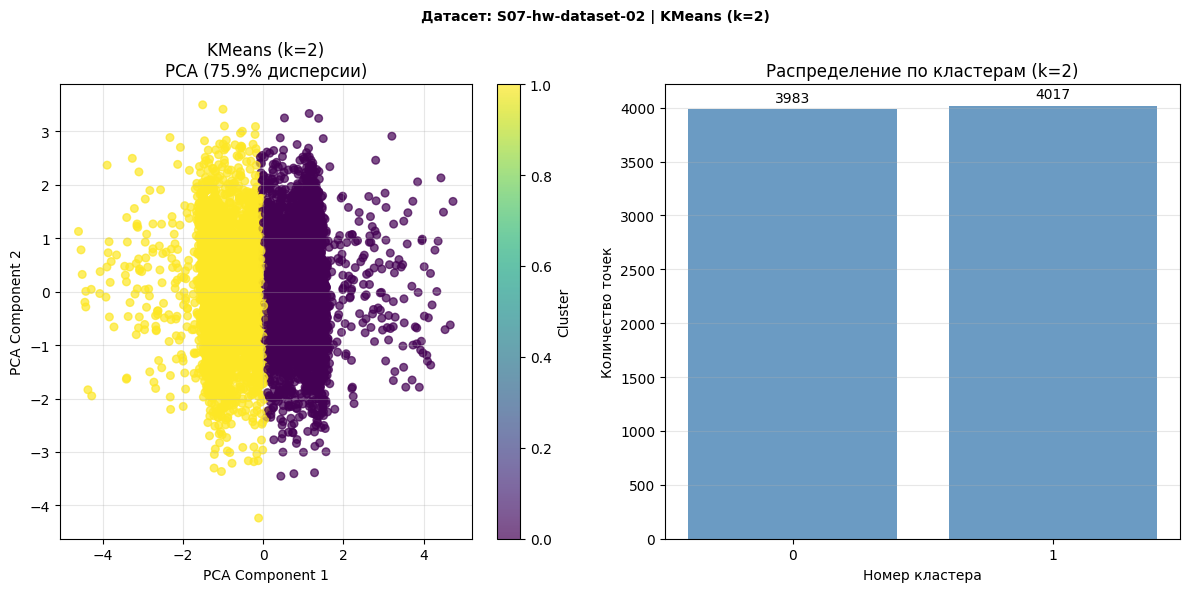

In [117]:
display(best_kmeans_result_second["figure"])
best_kmeans_result_second["figure"].savefig(f"{FIG_PATH}best_kmeans_second_dataset.png")

Изобразим зависимость `Silhouette-score` от `K`

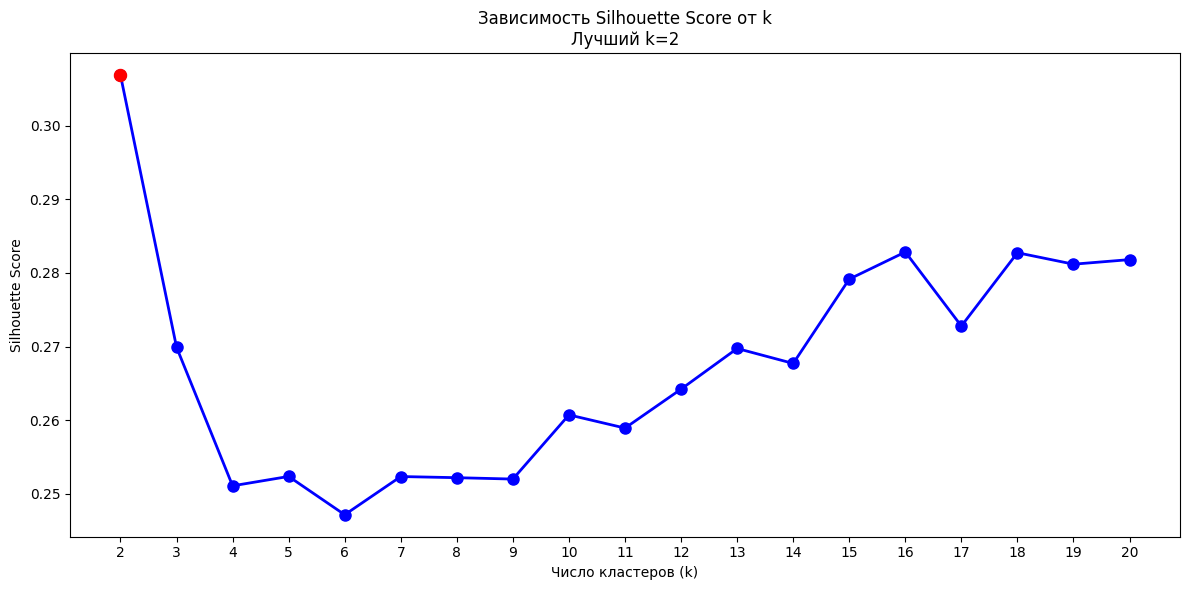

In [118]:
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.plot(K_ARR, silhouette_scores, 'bo-', linewidth=2, markersize=8)

ax.scatter(best_k_silhouette, best_silhouette, color='red', s=75, zorder=2)

ax.set_xlabel('Число кластеров (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title(f'Зависимость Silhouette Score от k\nЛучший k={best_k_silhouette}')

ax.set_xticks(K_ARR)
fig.savefig(f"{FIG_PATH}k_vs_s_sc_third_dataset.png")
plt.tight_layout()
plt.show()

Сохраним лучшую модель типа `KMeans`

In [119]:
add_kmeans_metrics(best_result=best_kmeans_result_second, dataset_name="S07-hw-dataset-02")
pass

##### 3.2.2. `DBSCAN`

Выполним перебор параметров для моделей `DBSCAN`

In [120]:
all_dbscan_results = []
valid_models = []

for eps in EPS:
    for min_samples in MIN_SAMPLES:
        result = rate_dbscan(
            X=second_X_scaled,
            eps=eps,
            min_samples=min_samples,
            dataset_name="S07-hw-dataset-02",
            plot_show=False
        )
        
        all_dbscan_results.append(result)
        
        # Добавляем в валидные только если ≥2 кластеров и метрика не NaN
        if result['n_clusters'] >= 2 and not np.isnan(result['silhouette']):
            valid_models.append(result)

best_dbscan_result_second = max(valid_models, 
                              key=lambda x: x['silhouette'])

print(f"\nЛучшие параметры DBSCAN: eps={best_dbscan_result_second['eps']}, min_samples={best_dbscan_result_second['min_samples']}")
print(f"Лучшее значение silhouette-score: {best_dbscan_result_second['silhouette']:.4f}")
print(f"Количество кластеров: {best_dbscan_result_second['n_clusters']}")
print(f"Доля шума: {best_dbscan_result_second['noise_ratio']:.1%}")



Лучшие параметры DBSCAN: eps=0.1, min_samples=10
Лучшее значение silhouette-score: 0.5812
Количество кластеров: 46
Доля шума: 91.8%


Получим информацию о метриках лучшей модели

In [121]:
print(f"МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: DBSCAN")
print("="*50)

print(f"Параметры модели:")
print(f"  - eps:                    {best_dbscan_result_second['eps']}")
print(f"  - min_samples:            {best_dbscan_result_second['min_samples']}")

print(f"\nОсновные метрики (без учёта шума):")
print(f"  - Silhouette Score:       {best_dbscan_result_second['silhouette']:.4f}")
print(f"  - Davies-Bouldin Score:   {best_dbscan_result_second['davies_bouldin']:.4f}")
print(f"  - Calinski-Harabasz Score: {best_dbscan_result_second['calinski_harabasz']:.1f}")

print(f"\nХарактеристики кластеризации:")
print(f"  - Количество кластеров:   {best_dbscan_result_second['n_clusters']}")
print(f"  - Доля шума:              {best_dbscan_result_second['noise_ratio']:.1%}")
print(f"  - Количество шумовых точек: {best_dbscan_result_second['n_noise']}")
print(f"  - Общее количество точек: {len(best_dbscan_result_second['labels'])}")

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: DBSCAN
Параметры модели:
  - eps:                    0.1
  - min_samples:            10

Основные метрики (без учёта шума):
  - Silhouette Score:       0.5812
  - Davies-Bouldin Score:   0.5780
  - Calinski-Harabasz Score: 2758.1

Характеристики кластеризации:
  - Количество кластеров:   46
  - Доля шума:              91.8%
  - Количество шумовых точек: 7348
  - Общее количество точек: 8000


Выведем информацию о лучшей модели

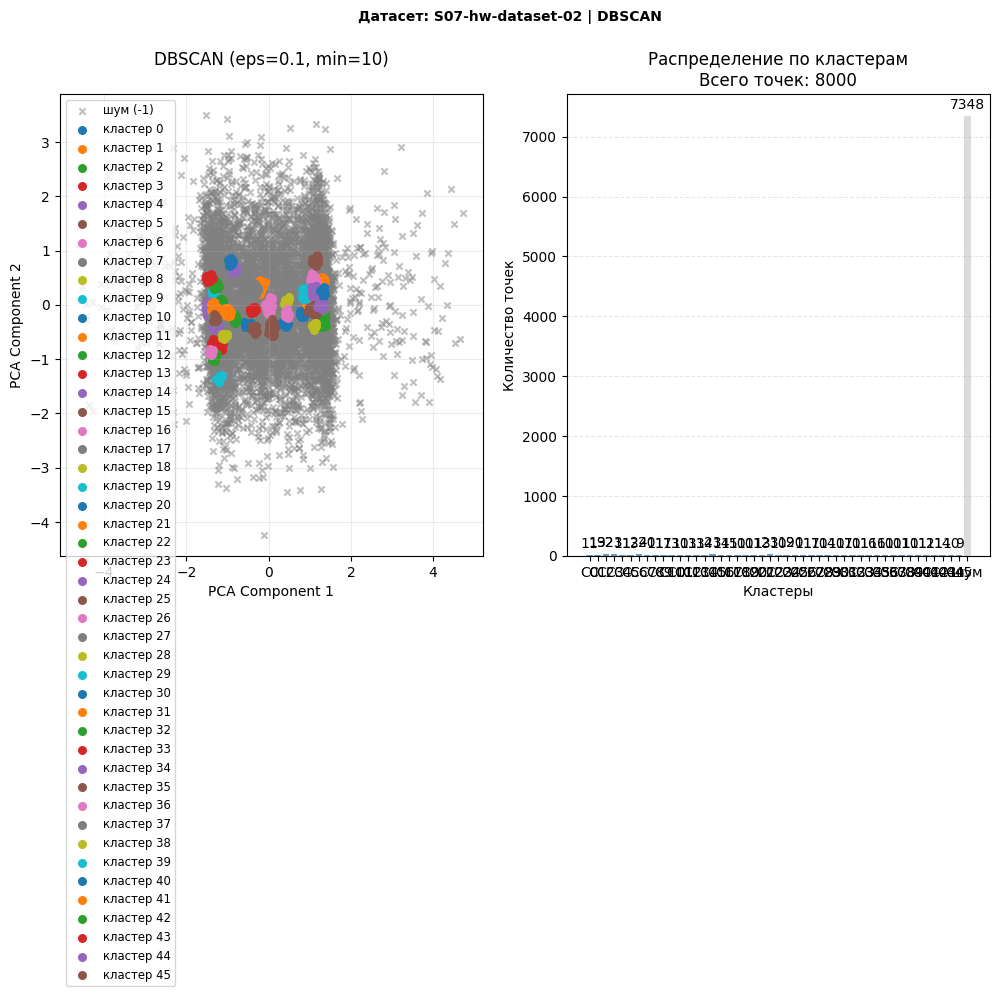

In [122]:
display(best_dbscan_result_second["figure"])
best_dbscan_result_second["figure"].savefig(f"{FIG_PATH}best_dbscan_second_dataset.png")

Сохраним лучшую модель типа `DBSCAN`

In [123]:
add_dbscan_metrics(best_result=best_dbscan_result_second, dataset_name="S07-hw-dataset-02")
pass

##### 3.2.3. Выводы по датасету `S07-hw-dataset-02.csv`

Проведем сравнительный анализ метрик лучших моделей `KMeans` и `DBSCAN` на данном датасете 

In [124]:
print("\n=== СРАВНИТЕЛЬНЫЙ АНАЛИЗ ===")
print(f"KMeans: silhouette={best_kmeans_result_second['silhouette']:.3f}, "
      f"Davies-Bouldin={best_kmeans_result_second['davies_bouldin']:.3f}, "
      f"Calinski-Harabasz={best_kmeans_result_second['calinski_harabasz']:.3f}, "
      f"кластеры={best_kmeans_result_second['n_clusters']}")
print(f"DBSCAN: silhouette={best_dbscan_result_second['silhouette']:.3f}, "
      f"Davies-Bouldin={best_dbscan_result_second['davies_bouldin']:.3f}, "
      f"Calvinski=Harabasz={best_dbscan_result_second['calinski_harabasz']:.3f}, "
      f"кластеры={best_dbscan_result_second['n_clusters']}, "
      f"шум={best_dbscan_result_second['noise_ratio']:.1%}")


=== СРАВНИТЕЛЬНЫЙ АНАЛИЗ ===
KMeans: silhouette=0.307, Davies-Bouldin=1.323, Calinski-Harabasz=3573.393, кластеры=2
DBSCAN: silhouette=0.581, Davies-Bouldin=0.578, Calvinski=Harabasz=2758.123, кластеры=46, шум=91.8%


Лучшая модель

In [125]:
best_model_result_second = best_kmeans_result_second
FINAL_CHOICES.append({
    "dataset_name": "S07-hw-dataset-02",
    "model": best_kmeans_result_second,
    "reason": "Несмотря на лучший силуэт у DBSCAN (0.581), он выделил 91.8% точек как шум, что делает результат неинтерпретируемым. "
    "KMeans с k=2 даёт осмысленное разделение на две сбалансированные группы. Признак z_noise оказался слишком доминирующим и "
    "разрушающим для кластеризации."
})

Сохраним результаты кластеризации в `labels_hw07_ds1.csv`

In [126]:
save_cluster_labels(f"{S_CSV_PATH}labels_hw07_ds2.csv", best_result=best_model_result_second, dataset_with_ids=second_dataset)
pass

Метки сохранены в ./data/artifacts/labels/labels_hw07_ds2.csv
Информация об итоговом датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   sample_id      8000 non-null   int64
 1   cluster_label  8000 non-null   int32
dtypes: int32(1), int64(1)
memory usage: 93.9 KB


None

**Итоги по датасету**

Данные содержали сильно различающиеся по масштабу признаки, в том числе доминирующий шумовой признак *z_noise*, что потребовало масштабирования и повлияло на результаты кластеризации.

`DBSCAN` показал лучшие значения по силуэт-коэффициенту (0.581 против 0.307 у `KMeans`) и индексу Дэвиса-Болдина (0.578 против 1.323), что указывает на лучшее внутреннее качество разделения для тех точек, которые алгоритм смог отнести к кластерам. Однако `DBSCAN` при оптимальных параметрах (*eps=0.1, min_samples=10*) выделил 92% точек как шум и создал 46 маленьких кластеров из оставшихся 8% данных, что делает результат практически неинтерпретируемым и неприемлемым для практического применения.`KMeans` с *k=2*, несмотря на более низкие формальные метрики, дал осмысленное разделение на две сбалансированные группы, что лучше соответствует задаче поиска общей структуры во всём датасете.

#### 3.3. Датасет `S07-hw-dataset-03.csv`

Рассмотрим модели `KMeans` и `DBSCAN` для первого датасета. Для `DBSCAN` оценка проводится только на точках, отнесённых к кластерам, исключая шумовые объекты.

##### 3.3.1. `KMeans` - К-средних

Переберем значения для K в диапазоне `K_ARR` и выберем лучшую модель по метрике `Silhouette Score`.

In [127]:
all_results_third = []
silhouette_scores = []

for k in K_ARR:
    result = rate_kmeans(
        X=third_X_scaled, 
        n_clusters=k, 
        n_init=N_INIT, 
        dataset_name="S07-hw-dataset-03",
        plot_show=False,
        random_state=RANDOM_STATE
    )
    
    all_results_third.append(result)
    silhouette_scores.append(result['silhouette'])

best_k_silhouette = K_ARR[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)
print(f"Лучшее число кластеров: {best_k_silhouette}")
print(f"Лучшее значение silhouette-score: {best_k_silhouette}")

best_result_idx = np.argmax(silhouette_scores)
best_kmeans_result_third = all_results_third[best_result_idx]

Лучшее число кластеров: 3
Лучшее значение silhouette-score: 3


Получим информацию о метриках лучшей модели

In [128]:
print(f"МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: KMeans с k = {best_k_silhouette}")
print("="*50)

print(f"Основные метрики:")
print(f"  - Silhouette Score:       {best_silhouette:.4f}")
print(f"  - Davies-Bouldin Score:   {best_kmeans_result_third['davies_bouldin']:.4f}")
print(f"  - Calinski-Harabasz Score: {best_kmeans_result_third['calinski_harabasz']:.1f}")
print(f"  - Inertia:                {best_kmeans_result_third['inertia']:.2f}")

print(f"\nХарактеристики кластеров:")
print(f"  - Количество кластеров:   {best_k_silhouette}")
print(f"  - Размеры кластеров:      {best_kmeans_result_third['cluster_sizes']}")

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: KMeans с k = 3
Основные метрики:
  - Silhouette Score:       0.3155
  - Davies-Bouldin Score:   1.1577
  - Calinski-Harabasz Score: 6957.2
  - Inertia:                31123.46

Характеристики кластеров:
  - Количество кластеров:   3
  - Размеры кластеров:      [3680 6417 4903]


Выведем информацию о лучшей модели

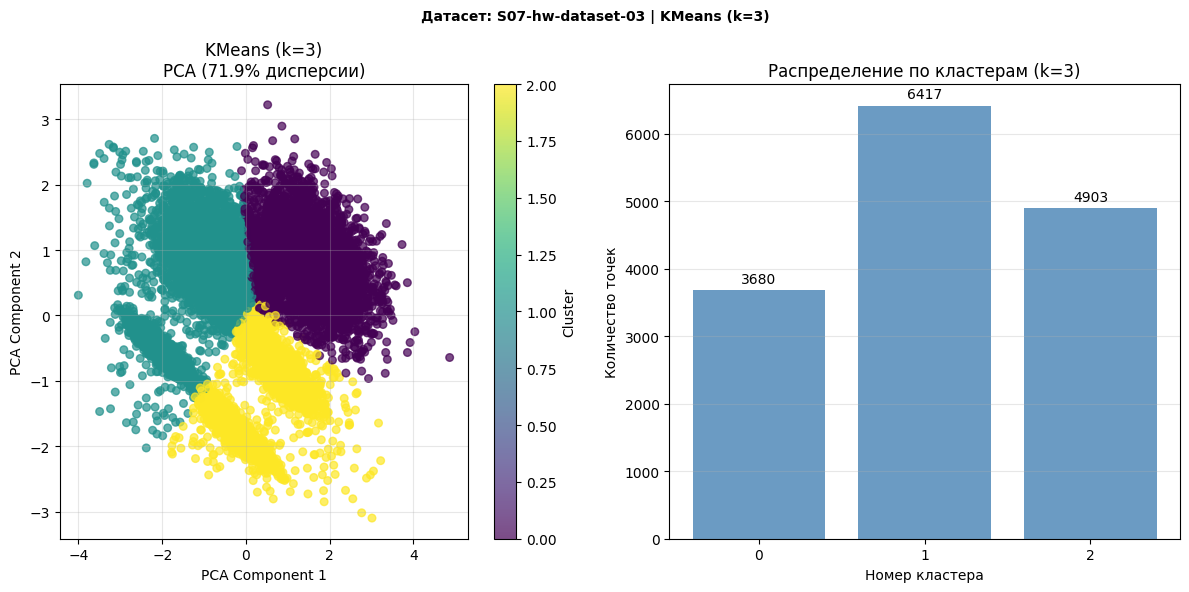

In [129]:
display(best_kmeans_result_third["figure"])
best_kmeans_result_third["figure"].savefig(f"{FIG_PATH}best_kmeans_third_dataset.png")

Изобразим зависимость `Silhouette-score` от `K`

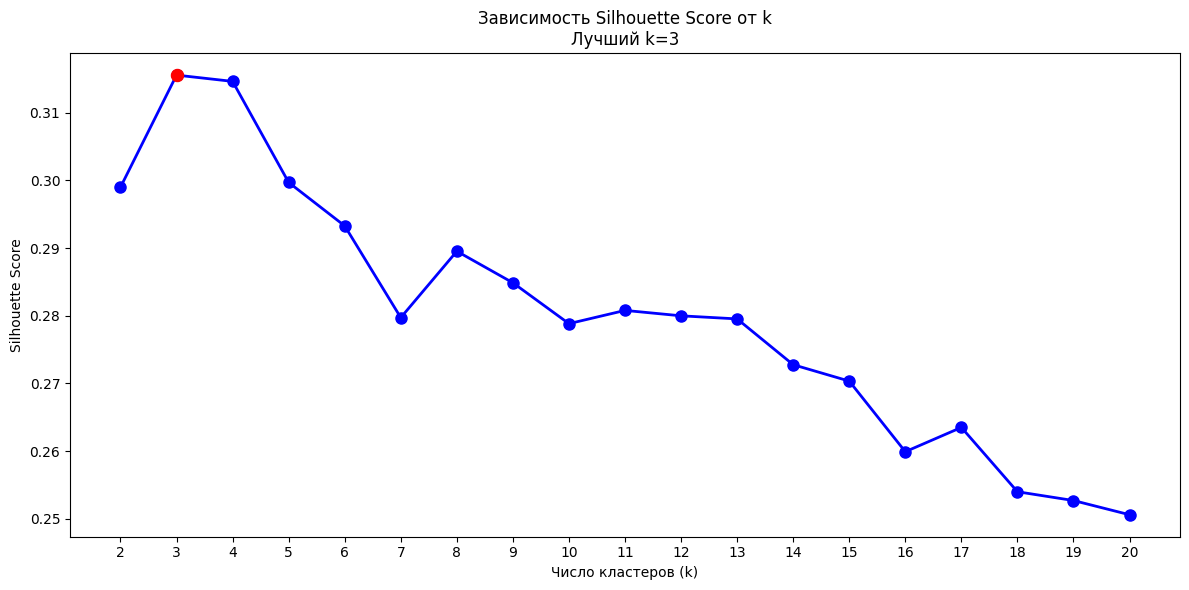

In [130]:
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.plot(K_ARR, silhouette_scores, 'bo-', linewidth=2, markersize=8)

ax.scatter(best_k_silhouette, best_silhouette, color='red', s=75, zorder=2)

ax.set_xlabel('Число кластеров (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title(f'Зависимость Silhouette Score от k\nЛучший k={best_k_silhouette}')

ax.set_xticks(K_ARR)
fig.savefig(f"{FIG_PATH}k_vs_s_sc_third_dataset.png")
plt.tight_layout()
plt.show()

Сохраним лучшую модель типа `KMeans`

In [131]:
add_kmeans_metrics(best_result=best_kmeans_result_second, dataset_name="S07-hw-dataset-03")
pass

##### 3.3.2. `DBSCAN`

Выполним перебор параметров для моделей `DBSCAN`

In [132]:
all_dbscan_results = []
valid_models = []

for eps in EPS:
    for min_samples in MIN_SAMPLES:
        result = rate_dbscan(
            X=third_X_scaled,
            eps=eps,
            min_samples=min_samples,
            dataset_name="S07-hw-dataset-03",
            plot_show=False
        )
        
        all_dbscan_results.append(result)
        
        # Добавляем в валидные только если ≥2 кластеров и метрика не NaN
        if result['n_clusters'] >= 2 and not np.isnan(result['silhouette']):
            valid_models.append(result)

best_dbscan_result_third = max(valid_models, 
                              key=lambda x: x['silhouette'])

print(f"\nЛучшие параметры DBSCAN: eps={best_dbscan_result_third['eps']}, min_samples={best_dbscan_result_third['min_samples']}")
print(f"Лучшее значение silhouette-score: {best_dbscan_result_third['silhouette']:.4f}")
print(f"Количество кластеров: {best_dbscan_result_third['n_clusters']}")
print(f"Доля шума: {best_dbscan_result_third['noise_ratio']:.1%}")



Лучшие параметры DBSCAN: eps=0.1, min_samples=10
Лучшее значение silhouette-score: 0.8121
Количество кластеров: 5
Доля шума: 99.6%


Получим информацию о метриках лучшей модели

In [133]:
print(f"МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: DBSCAN")
print("="*50)

print(f"Параметры модели:")
print(f"  - eps:                    {best_dbscan_result_third['eps']}")
print(f"  - min_samples:            {best_dbscan_result_third['min_samples']}")

print(f"\nОсновные метрики (без учёта шума):")
print(f"  - Silhouette Score:       {best_dbscan_result_third['silhouette']:.4f}")
print(f"  - Davies-Bouldin Score:   {best_dbscan_result_third['davies_bouldin']:.4f}")
print(f"  - Calinski-Harabasz Score: {best_dbscan_result_third['calinski_harabasz']:.1f}")

print(f"\nХарактеристики кластеризации:")
print(f"  - Количество кластеров:   {best_dbscan_result_third['n_clusters']}")
print(f"  - Доля шума:              {best_dbscan_result_third['noise_ratio']:.1%}")
print(f"  - Количество шумовых точек: {best_dbscan_result_third['n_noise']}")
print(f"  - Общее количество точек: {len(best_dbscan_result_third['labels'])}")

МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ: DBSCAN
Параметры модели:
  - eps:                    0.1
  - min_samples:            10

Основные метрики (без учёта шума):
  - Silhouette Score:       0.8121
  - Davies-Bouldin Score:   0.2449
  - Calinski-Harabasz Score: 3564.0

Характеристики кластеризации:
  - Количество кластеров:   5
  - Доля шума:              99.6%
  - Количество шумовых точек: 14939
  - Общее количество точек: 15000


Выведем информацию о лучшей модели

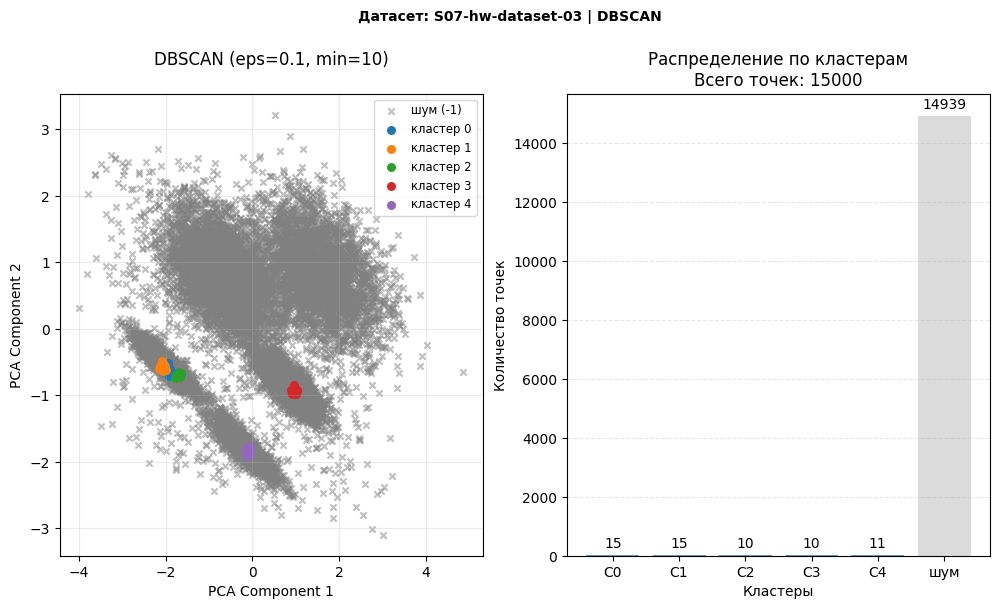

In [ ]:
display(best_dbscan_result_third["figure"])
best_dbscan_result_third["figure"].savefig(f"{FIG_PATH}best_dbscan_third_dataset.png")

Сохраним лучшую модель типа `DBSCAN`

In [135]:
add_dbscan_metrics(best_result=best_dbscan_result_third, dataset_name="S07-hw-dataset-03")
pass

##### 3.3.3. Выводы по датасету `S07-hw-dataset-03.csv`

Проведем сравнительный анализ метрик лучших моделей `KMeans` и `DBSCAN` на данном датасете 

In [136]:
print("\n=== СРАВНИТЕЛЬНЫЙ АНАЛИЗ ===")
print(f"KMeans: silhouette={best_kmeans_result_third['silhouette']:.3f}, "
      f"Davies-Bouldin={best_kmeans_result_third['davies_bouldin']:.3f}, "
      f"Calinski-Harabasz={best_kmeans_result_third['calinski_harabasz']:.3f}, "
      f"кластеры={best_kmeans_result_third['n_clusters']}")
print(f"DBSCAN: silhouette={best_dbscan_result_third['silhouette']:.3f}, "
      f"Davies-Bouldin={best_dbscan_result_third['davies_bouldin']:.3f}, "
      f"Calvinski=Harabasz={best_dbscan_result_third['calinski_harabasz']:.3f}, "
      f"кластеры={best_dbscan_result_third['n_clusters']}, "
      f"шум={best_dbscan_result_third['noise_ratio']:.1%}")


=== СРАВНИТЕЛЬНЫЙ АНАЛИЗ ===
KMeans: silhouette=0.316, Davies-Bouldin=1.158, Calinski-Harabasz=6957.163, кластеры=3
DBSCAN: silhouette=0.812, Davies-Bouldin=0.245, Calvinski=Harabasz=3564.021, кластеры=5, шум=99.6%


Лучшая модель

In [137]:
best_model_result_third = best_kmeans_result_third
FINAL_CHOICES.append({
    "dataset_name": "S07-hw-dataset-03",
    "model": best_kmeans_result_third,
    "reason": "DBSCAN выявил, что данные содержат 99.6% шума, что делает плотностную кластеризацию бессмысленной. "
    "Хотя формальные метрики DBSCAN выше, результат (5 кластеров из 0.4% данных) не имеет практической ценности. KMeans с k=3 "
    "обеспечивает осмысленное разделение всего датасета на три сбалансированные группы, что соответствует реальной задаче кластеризации."
})

Сохраним результаты кластеризации в `labels_hw07_ds1.csv`

In [138]:
save_cluster_labels(f"{S_CSV_PATH}labels_hw07_ds3.csv", best_result=best_model_result_third, dataset_with_ids=third_dataset)
pass

Метки сохранены в ./data/artifacts/labels/labels_hw07_ds3.csv
Информация об итоговом датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   sample_id      15000 non-null  int64
 1   cluster_label  15000 non-null  int32
dtypes: int32(1), int64(1)
memory usage: 175.9 KB


None

**Итоги по датасету**

Данные демонстрируют ещё более выраженную проблему с выбросами, чем предыдущий датасет. Признаки имеют разные масштабы, и присутствие шумового признака *f_noise* существенно влияет на результаты кластеризации.

`DBSCAN` показал исключительно высокий силуэт-коэффициент (0.812) и очень низкий индекс Дэвиса-Болдина (0.245), что говорит об идеальном разделении тех немногих точек, которые алгоритм смог отнести к кластерам. Однако критически важным является тот факт, что `DBSCAN` классифицировал 99.6% точек как шум, оставив лишь 0.4% данных (5 маленьких кластеров) как структурированную информацию. Такой результат, хотя и метрически превосходный, совершенно бесполезен для практического анализа всего датасета.

`KMeans` с *k=3*, несмотря на скромные формальные показатели (*silhouette=0.316*), дал осмысленное и сбалансированное разделение на три группы, охватывающее все точки датасета. Высочайший процент шума, выявленный `DBSCAN`, свидетельствует о том, что данные практически полностью состоят из выбросов с точки зрения плотностной кластеризации, и любая попытка найти в них плотные сгустки обречена на выделение лишь единичных точек. В таких условиях `KMeans` оказывается лучшим выбором, обеспечивающим хоть какую-то работоспособную структуризацию данных.

#### 3.4. Сохранение данных

Сохраним все метрики и данные по моделям для каждого датасета в `metrics_summary.json`

In [139]:
save_metrics_to_json()
pass

Сохраним конфигурации лучших моделей для каждого датасета в `best_configs.json`

In [140]:
save_final_choices_to_json()
pass

### 4. Проверка устойчивости

Выполним мини-проверку устойчивости. Для этого выполним 5 запусков с разными random_state для лучшей модели `KMeans` для датасета `S07-hw-dataset-03.csv`.

In [141]:
reference = best_kmeans_result_third
best_k = 3  # вычислена ранее
print(f"Исходный (random_state={RANDOM_STATE}):")
print(f"  - Silhouette:      {reference['silhouette']:.4f}")
print(f"  - Davies-Bouldin:  {reference['davies_bouldin']:.4f}")
print(f"  - Calinski-Harabasz: {reference['calinski_harabasz']:.1f}")
print(f"  - Inertia:         {reference['inertia']:.2f}")
print(f"  - Размеры кластеров: {reference['cluster_sizes']}")

random_states = [42, 123, 456, 789, 999]
results = []
all_labels = [reference['labels']]  # Для ARI

Исходный (random_state=39):
  - Silhouette:      0.3155
  - Davies-Bouldin:  1.1577
  - Calinski-Harabasz: 6957.2
  - Inertia:         31123.46
  - Размеры кластеров: [3680 6417 4903]


In [142]:
print("ЗАПУСКИ С РАЗНЫМИ RANDOM_STATE:")
for i, rs in enumerate(random_states):
    result = rate_kmeans(
        X=third_X_scaled,
        n_clusters=best_k,
        n_init=N_INIT,
        dataset_name=f"S07-hw-dataset-03 (test {i+1})",
        plot_show=False,
        random_state=rs
    )
    
    results.append(result)
    all_labels.append(result['labels'])
    
    print(f"\nЗапуск {i+1} (random_state={rs}):")
    print(f"  Silhouette:      {result['silhouette']:.4f} (delta={result['silhouette']-reference['silhouette']:+.4f})")
    print(f"  Davies-Bouldin:  {result['davies_bouldin']:.4f} (delta={result['davies_bouldin']-reference['davies_bouldin']:+.4f})")
    print(f"  Calinski-Harabasz: {result['calinski_harabasz']:.1f} (delta={result['calinski_harabasz']-reference['calinski_harabasz']:+.1f})")
    print(f"  Inertia:         {result['inertia']:.2f} (delta={result['inertia']-reference['inertia']:+.2f})")
    print(f"  Размеры кластеров: {result['cluster_sizes']}")

ЗАПУСКИ С РАЗНЫМИ RANDOM_STATE:

Запуск 1 (random_state=42):
  Silhouette:      0.3155 (delta=+0.0000)
  Davies-Bouldin:  1.1577 (delta=+0.0000)
  Calinski-Harabasz: 6957.2 (delta=+0.0)
  Inertia:         31123.46 (delta=-0.00)
  Размеры кластеров: [6417 4903 3680]

Запуск 2 (random_state=123):
  Silhouette:      0.3155 (delta=+0.0000)
  Davies-Bouldin:  1.1577 (delta=+0.0000)
  Calinski-Harabasz: 6957.2 (delta=+0.0)
  Inertia:         31123.45 (delta=-0.01)
  Размеры кластеров: [3680 6417 4903]

Запуск 3 (random_state=456):
  Silhouette:      0.3155 (delta=+0.0000)
  Davies-Bouldin:  1.1577 (delta=+0.0000)
  Calinski-Harabasz: 6957.2 (delta=+0.0)
  Inertia:         31123.44 (delta=-0.02)
  Размеры кластеров: [3680 4903 6417]

Запуск 4 (random_state=789):
  Silhouette:      0.3155 (delta=+0.0000)
  Davies-Bouldin:  1.1577 (delta=+0.0000)
  Calinski-Harabasz: 6957.2 (delta=+0.0)
  Inertia:         31123.46 (delta=+0.00)
  Размеры кластеров: [6417 3680 4903]

Запуск 5 (random_state=999):

In [143]:
print("ARI между эталоном и другими запусками:")
ari_vs_reference = []
for i, labels in enumerate(all_labels[1:], 1):  # пропускаем эталон (первый элемент)
    ari = adjusted_rand_score(all_labels[0], labels)  # сравнение с эталоном
    ari_vs_reference.append(ari)
    print(f"  Исходный vs Запуск {i} (random_state={random_states[i-1]}): ARI = {ari:.4f}")

print(f"\nСредний ARI относительно эталона: {np.mean(ari_vs_reference):.4f}")
print(f"Стандартное отклонение: {np.std(ari_vs_reference):.4f}")

ARI между эталоном и другими запусками:
  Исходный vs Запуск 1 (random_state=42): ARI = 1.0000
  Исходный vs Запуск 2 (random_state=123): ARI = 1.0000
  Исходный vs Запуск 3 (random_state=456): ARI = 1.0000
  Исходный vs Запуск 4 (random_state=789): ARI = 1.0000
  Исходный vs Запуск 5 (random_state=999): ARI = 1.0000

Средний ARI относительно эталона: 1.0000
Стандартное отклонение: 0.0000


In [144]:
print("АНАЛИЗ УСТОЙЧИВОСТИ МЕТРИК:")


silhouettes = [r['silhouette'] for r in results]
davies_bouldins = [r['davies_bouldin'] for r in results]
calinskis = [r['calinski_harabasz'] for r in results]
inertias = [r['inertia'] for r in results]

print(f"\nSilhouette Score:")
print(f"  Среднее: {np.mean(silhouettes):.4f} ± {np.std(silhouettes):.4f}")
print(f"  Разброс: от {np.min(silhouettes):.4f} до {np.max(silhouettes):.4f}")

print(f"\nDavies-Bouldin Index:")
print(f"  Среднее: {np.mean(davies_bouldins):.4f} ± {np.std(davies_bouldins):.4f}")
print(f"  Разброс: от {np.min(davies_bouldins):.4f} до {np.max(davies_bouldins):.4f}")

print(f"\nCalinski-Harabasz Index:")
print(f"  Среднее: {np.mean(calinskis):.1f} ± {np.std(calinskis):.1f}")
print(f"  Разброс: от {np.min(calinskis):.1f} до {np.max(calinskis):.1f}")

print(f"\nInertia:")
print(f"  Среднее: {np.mean(inertias):.2f} ± {np.std(inertias):.2f}")
print(f"  Разброс: от {np.min(inertias):.2f} до {np.max(inertias):.2f}")

АНАЛИЗ УСТОЙЧИВОСТИ МЕТРИК:

Silhouette Score:
  Среднее: 0.3155 ± 0.0000
  Разброс: от 0.3155 до 0.3155

Davies-Bouldin Index:
  Среднее: 1.1577 ± 0.0000
  Разброс: от 1.1577 до 1.1577

Calinski-Harabasz Index:
  Среднее: 6957.2 ± 0.0
  Разброс: от 6957.2 до 6957.2

Inertia:
  Среднее: 31123.45 ± 0.01
  Разброс: от 31123.44 до 31123.46


**Выводы**

`KMeans` продемонстрировал хорошую устойчивость при различных инициализациях. Adjusted Rand Index (ARI) между всеми запусками составил 1.0000, что означает полное совпадение кластеризаций независимо от выбранного *random_state*.

- Silhouette Score: Все 5 запусков показали идентичное значение 0.3155

- Davies-Bouldin Index: Константное значение 1.1577

- Calinski-Harabasz Index: Стабильное значение 6957.2 

- Inertia: Практически одинаковое значение 31123.45 (минимальные колебания +-0.01)

Для датасета *S07-hw-dataset-03.csv* можно использовать KMeans с k=3, так как алгоритм демонстрирует хорошую устойчивость и стабильные метрики качества при различных инициализациях (*random_state*).